In [1]:
# import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import linprog

/Users/jStrange/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# User Inputs for Lead Time Distribution
poisson_lambda = 3
simulation_periods = 20

# Define Supply Chain Structure
suppliers = ["S1"]
distributors = ["D1", "D2"]
retailers = ["R1", "R2", "R3", "R4", "R5", "R6"]

# Generate Cost Matrix (Supplier → Distributor → Retailer)
cost_matrix = {
    "S1": {"D1": 5, "D2": 6},
    "D1": {"R1": 2, "R2": 3, "R3": 4},
    "D2": {"R4": 2, "R5": 3, "R6": 4},
}

# Generate Lead Times (Poisson-distributed)
lead_times = {
    "S1": {"D1": np.random.poisson(poisson_lambda), "D2": np.random.poisson(poisson_lambda)},
    "D1": {"R1": np.random.poisson(poisson_lambda), "R2": np.random.poisson(poisson_lambda), "R3": np.random.poisson(poisson_lambda)},
    "D2": {"R4": np.random.poisson(poisson_lambda), "R5": np.random.poisson(poisson_lambda), "R6": np.random.poisson(poisson_lambda)},
}

# Generate Demand Time Series (Linear Trend)
time_periods = np.arange(1, simulation_periods + 1)
demand_trend = 50 + 2 * time_periods + np.random.normal(0, 5, simulation_periods)

In [3]:
# Define Linear Programming Model
num_vars = len(distributors) + len(retailers)  # Inventory decision variables (for distributors and retailers)
c = np.ones(num_vars)  # Objective: Minimize total inventory

# Constraints: Demand fulfillment at retailers and flow balance at distributors
A_eq = []
b_eq = []

# Demand fulfillment constraints
for i, retailer in enumerate(retailers):
    row = [0] * num_vars
    row[i + len(distributors)] = 1  # Retail inventory variable
    A_eq.append(row)
    b_eq.append(demand_trend[-1])  # Last period's demand

# Flow balance constraints at distributors
for i, distributor in enumerate(distributors):
    row = [0] * num_vars
    row[i] = -1  # Distributor inventory variable
    for j, retailer in enumerate(retailers):
        if retailer in cost_matrix[distributor]:
            row[j + len(distributors)] = 1  # Retail inventory variables
    A_eq.append(row)
    b_eq.append(0)  # Flow balance

# Solve Linear Program
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=[(0, None)] * num_vars, method='highs')

# Extract Optimized Inventory Levels
optimized_inventory = res.x if res.success else np.zeros(num_vars)

distributor_inventory = optimized_inventory[: len(distributors)]
retailer_inventory = optimized_inventory[len(distributors) :]

/var/folders/13/tb353hv16bg0qsrdngc6r2v40000gn/T/ipykernel_20498/201186391.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


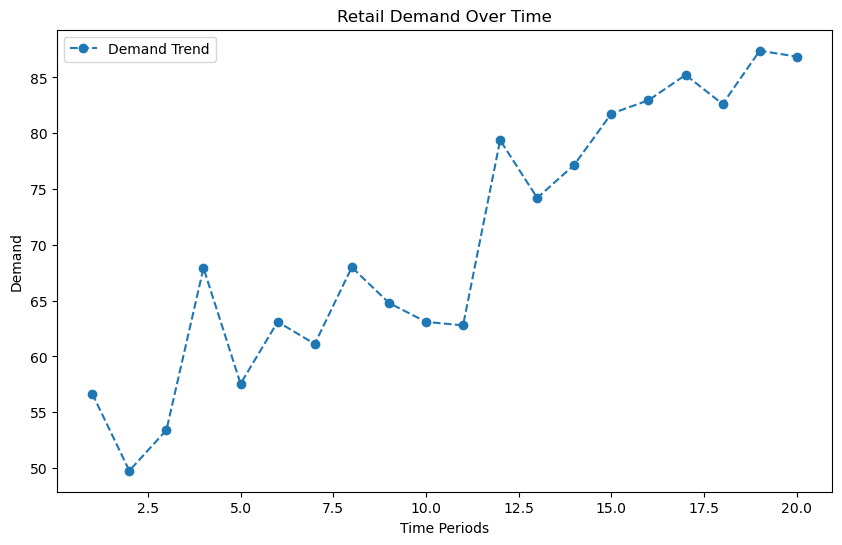

In [4]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(time_periods, demand_trend, label="Demand Trend", linestyle="--", marker="o")
ax.set_title("Retail Demand Over Time")
ax.set_xlabel("Time Periods")
ax.set_ylabel("Demand")
ax.legend()
fig.show()

In [5]:
df_inventory = pd.DataFrame({
    "Location": distributors + retailers,
    "Optimized Inventory": optimized_inventory,
})
display(df_inventory)

,Location,Optimized Inventory
0,D1,260.607813
1,D2,260.607813
2,R1,86.869271
3,R2,86.869271
4,R3,86.869271
5,R4,86.869271
6,R5,86.869271
7,R6,86.869271
